In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob
from enum import Enum


In [2]:
train = pd.read_csv('../data/preprocessed_train.csv')
test = pd.read_csv('../data/preprocessed_test.csv')

In [3]:
train.head()

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,True
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,False
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",True
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,True
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,True


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20691 entries, 0 to 20690
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20173 non-null  object
 1   author  18759 non-null  object
 2   text    20652 non-null  object
 3   label   20691 non-null  bool  
dtypes: bool(1), object(3)
memory usage: 505.3+ KB


In [5]:
test.head()

,title,author,text
0,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
2,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
3,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
4,Pelosi Calls for FBI Investigation to Find Out...,Pam Key,"Sunday on NBC’s “Meet the Press,” House Minori..."


# EDA

## Pie Chart

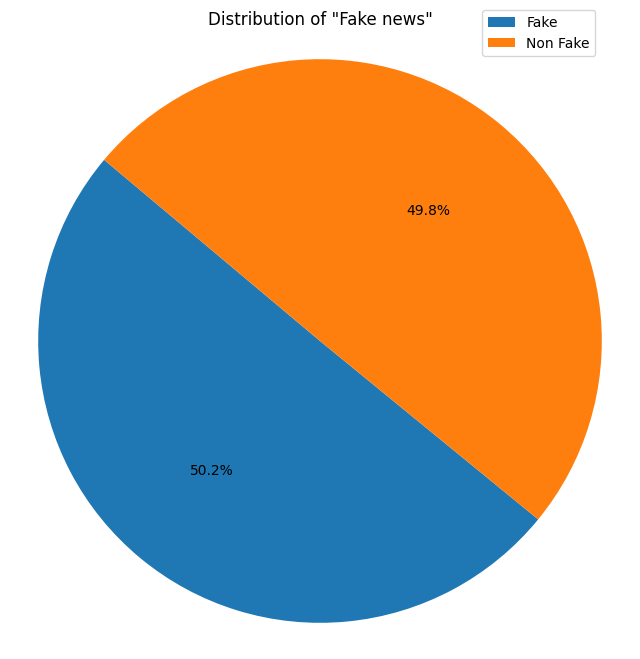

In [6]:
type_counts = train['label'].value_counts()
labels = ['Fake', 'Non Fake']

plt.figure(figsize=(8, 8))
plt.pie(type_counts, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of "Fake news"')

plt.legend(labels, loc="center left", bbox_to_anchor=(0.75, 1))

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Title word cloud

In [7]:
fake_news_df = train[train['label'] == True].copy()
non_fake_news_df = train[train['label'] == False].copy()

In [9]:
wordcloud_fake = WordCloud(width=800, height=400, random_state=123, background_color='white').generate(fake_news_df['text'].to_string())

In [10]:
wordcloud_non_fake = WordCloud(width=800, height=400, random_state=123, background_color='white').generate(non_fake_news_df['text'].to_string())

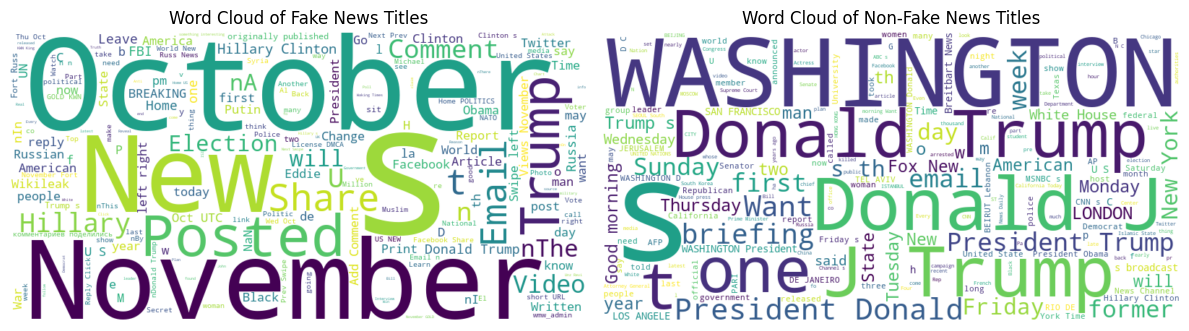

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title('Word Cloud of Fake News Titles')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_fake, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title('Word Cloud of Non-Fake News Titles')

plt.tight_layout()
plt.show()

## Sentiment Analysis

### Sentiment Scatter

In [16]:
fake_news_df['title_sentiment'] = fake_news_df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
fake_news_df['content_sentiment'] = fake_news_df['text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

non_fake_news_df['title_sentiment'] = non_fake_news_df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
non_fake_news_df['content_sentiment'] = non_fake_news_df['text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

TypeError: The `text` argument passed to `__init__(text)` must be a string, not <class 'float'>

In [32]:
# Calculate correlation between title and content sentiment for both DataFrames
fake_correlation = fake_news_df[['content_sentiment', 'title_sentiment']].corr().iloc[0, 1]
non_fake_correlation = non_fake_news_df[['content_sentiment', 'title_sentiment']].corr().iloc[0, 1]

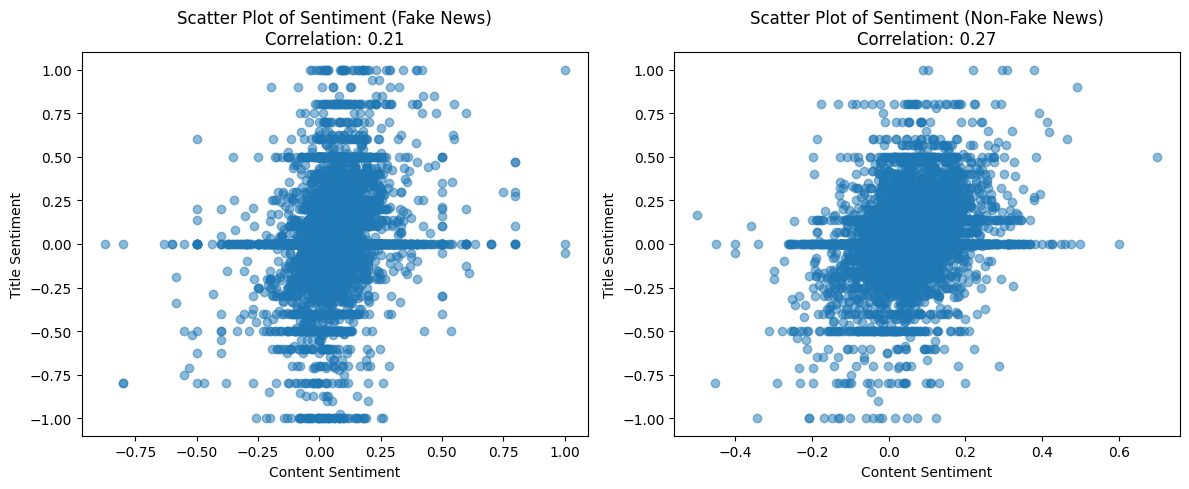

In [33]:
# Create scatter plots for "fake" and "non-fake" news with correlation in title
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(fake_news_df['content_sentiment'], fake_news_df['title_sentiment'], alpha=0.5)
plt.xlabel('Content Sentiment')
plt.ylabel('Title Sentiment')
plt.title(f'Scatter Plot of Sentiment (Fake News)\nCorrelation: {fake_correlation:.2f}')

plt.subplot(1, 2, 2)
plt.scatter(non_fake_news_df['content_sentiment'], non_fake_news_df['title_sentiment'], alpha=0.5)
plt.xlabel('Content Sentiment')
plt.ylabel('Title Sentiment')
plt.title(f'Scatter Plot of Sentiment (Non-Fake News)\nCorrelation: {non_fake_correlation:.2f}')

plt.tight_layout()
plt.show()

### Sentiment heatmap

In [42]:
class Polarity(Enum):
    NEGATIVE = 0
    NEUTRAL = 1
    POSITIVE = 2

def discretize_sentiment(polarity):
    if polarity < -1/3: return Polarity.NEGATIVE.name
    elif -1/3 <= polarity <= 1/3: return Polarity.NEUTRAL.name
    return Polarity.POSITIVE.name

fake_news_df['title_sentiment_category'] = fake_news_df['title_sentiment'].apply(discretize_sentiment)
fake_news_df['content_sentiment_category'] = fake_news_df['content_sentiment'].apply(discretize_sentiment)

non_fake_news_df['title_sentiment_category'] = non_fake_news_df['title_sentiment'].apply(discretize_sentiment)
non_fake_news_df['content_sentiment_category'] = non_fake_news_df['content_sentiment'].apply(discretize_sentiment)

In [43]:
polarities = [polarity.name for polarity in Polarity]
polarities

['NEGATIVE', 'NEUTRAL', 'POSITIVE']

In [44]:
# Create pivot tables for the heatmaps and fill missing values


pivot_fake = fake_news_df.pivot_table(index='title_sentiment_category', columns='content_sentiment_category', aggfunc='size', fill_value=0)
pivot_fake = pivot_fake.reindex(columns=polarities, index=polarities, fill_value=0)

pivot_non_fake = non_fake_news_df.pivot_table(index='title_sentiment_category', columns='content_sentiment_category', aggfunc='size', fill_value=0)
pivot_non_fake = pivot_non_fake.reindex(columns=polarities, index=polarities, fill_value=0)

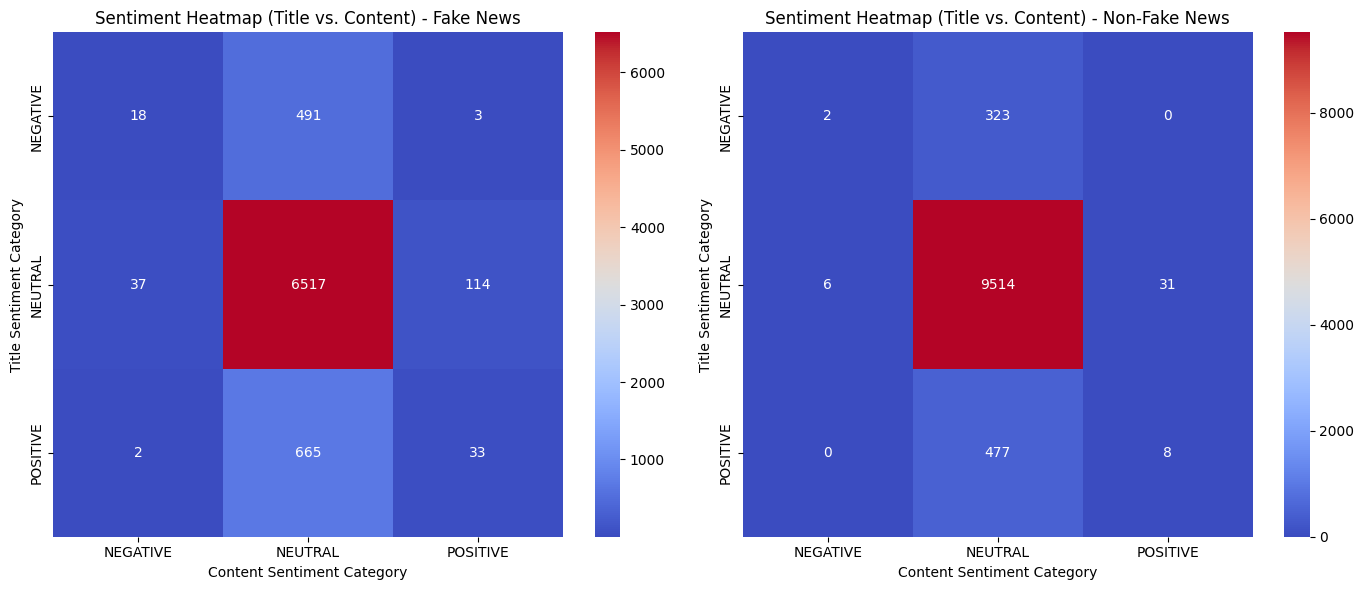

In [45]:
# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the heatmap for "fake" news
sns.heatmap(pivot_fake, annot=True, fmt='d', cmap='coolwarm', cbar=True, ax=axes[0])
axes[0].set_xlabel('Content Sentiment Category')
axes[0].set_ylabel('Title Sentiment Category')
axes[0].set_title('Sentiment Heatmap (Title vs. Content) - Fake News')

# Plot the heatmap for "non-fake" news
sns.heatmap(pivot_non_fake, annot=True, fmt='d', cmap='coolwarm', cbar=True, ax=axes[1])
axes[1].set_xlabel('Content Sentiment Category')
axes[1].set_ylabel('Title Sentiment Category')
axes[1].set_title('Sentiment Heatmap (Title vs. Content) - Non-Fake News')

plt.tight_layout()
plt.show()